The soil water balance represents a quantitative framework for assessing water fluxes within the soil system. It soil water balance accounts for the incoming water fluxes such as precipitation (P) and irrigation (I), and the outgoing water fluxes, which include evapotranspiration (ET), surface runoff (R), canopy interception (Ic), and deep percolation or leaching (D). The equation can be represented as `ΔS = P + I - ET - R - Tc - D`, where `ΔS` denotes the change in soil water storage over a specified period. This balance is essential for predicting soil moisture conditions, estimating crop water stress, and guiding irrigation scheduling. This tutorial will integrate water inputs, outputs, and storage to describe soil water dynamics in the rotzone, which is typically required in hydrologic and agronomic applications. The model that we are going to implement for rainfed conditions looks like this:

$$ S_t = S_{t-1} + P_t - ETo_t Kc_t - R_t - Ic - D_t$$

$S_t$ (mm) is the soil water storage over the rootzone at the end of the day $t$

$S_{t-1}$ (mm) is the soil water storage over the rootzone at the beginning of the day $t$

$P$ (mm) is daily precipitation and $I$ is daily irrigation during time $t$ (i.e., in this case one day). The model will be developed for rainfed conditions, so $I$ will be assumed zero.

$Ic$ (mm) is canopy and litter interception. The term $P-Ic$ is often known as effective precipitation, which is the input water that reaches the soil surface. In this model interception will be assumed constant, which means that days with $P <= Ic$ will result in no water reaching the soil surface.

$ETo$ (mm) is the potential evapotrasnpiration defined for a reference crop growing under well-watered conditions. This term accounts for both soil evaporative losses and plant transpiration.

$Kc$ (dimensionless) is an empirical crop coefficient to adjust the potential evapotranspiration for the current crop conditions. This crop coefficeint changes as a function of the phenological stages of the crop. This variable often resembles the curve of green canopy cover.

$R$ (mm) is surface runoff, which in this case will be modeled using the curve number method

$D$ (mm) is drainage below the bottom of the rootzone, which will be modeled using the Wilcox method.


In [34]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Define auxiliary functions

To avoid clutter in our main function, we will create a set of helper functions dedicated to compute some of the proceses of the soil water balance. While this is not necessary, it will make our code cleaner, easier to read, and more modular.

In [35]:
# Define auxiliary functions for individual processes

def compute_runoff(P,CN):
    """
    Daily runoff based on the U.S. Soil Conservation Service curve number method.
    """
    S = 25400/CN - 254; # Maximum soil moisture retention after runoff begins.
    Ia = S * 0.05; # Initial abstraction (Ia). Rainfall before runoff starts to occur.
    if P > Ia:
        R = (P - Ia)**2 / (P - Ia + S);
    else:
        R = 0
    return R


def compute_drainage(S,S_max,D_max):
    """
    Wilcox-type equation to simulate deep percolation as a function of soil water storage.
    """
    D = D_max*(S/S_max)**((D_max/S_max - 1)/(-D_max/S_max))
    return D


def compute_potential_et(T_avg,solar_rad,altitude):
    """
    Potential evapotranspiration based on the Priestley-Taylor method proposed in 1972.
    """
    atm_pressure = 101.3 * ((293 - 0.0065 * altitude)/293)**5.26 # kPa
    gamma = 0.000665 * atm_pressure # Psychrometric constant Cp/(2.45 * 0.622 = 0.000665
    delta = 4098 * (0.6108 * np.exp(17.27 * T_avg / (T_avg  + 237.3))) / (T_avg  + 237.3)**2 # Slope of saturation vapor pressure
    soil_heat_flux = 0
    alpha = 1.26 # empirical coefficient typically set to 1.26 for wet surfaces
    PET = alpha*delta/(delta+gamma)*(solar_rad-soil_heat_flux)
    PET =  PET**0.75 # Estimate reference ET from potential ET over open water. See page 88 in Priestley-Taylor, 1972.
    return PET

def compute_gdd(T_avg, T_base):
    """
    Function to compute growing degree days.
    """
    if T_avg > T_base:
        gdd = T_avg - T_base
    else:
        gdd = 0
    return gdd


## Load weather data

We will use a long time series of weather data from the ACME weather station of the Oklahoma Mesonet.

In [36]:
# Load data
df = pd.read_csv('../datasets/acme_ok_daily.csv')

# Check for missing values
df.isna().sum()

df.head()

,Date,DOY,TMAX,TMIN,RAIN,HMAX,HMIN,ATOT,W2AVG,ETgrass
0,1/1/05 0:00,1,21.161111,14.272222,0.00,97.5,65.97,4.09,5.194592,1.976940
1,1/2/05 0:00,2,21.261111,4.794444,0.00,99.3,77.37,4.11,3.428788,1.302427
2,1/3/05 0:00,3,5.855556,3.477778,2.54,99.8,98.20,2.98,3.249973,0.349413
3,1/4/05 0:00,4,4.644444,0.883333,7.62,99.6,98.50,1.21,3.527137,0.288802
4,1/5/05 0:00,5,0.827778,-9.172222,24.13,99.4,86.80,1.65,NaN,0.367956


In [37]:
# Fill missing values
df['TMAX'].interpolate(method='pchip', inplace=True)
df['TMIN'].interpolate(method='pchip', inplace=True)
df['HMAX'].interpolate(method='pchip', inplace=True)
df['HMIN'].interpolate(method='pchip', inplace=True)
df['ATOT'].interpolate(method='pchip', inplace=True)
df['W2AVG'].interpolate(method='pchip', inplace=True)
df['RAIN'].interpolate(method='zero', inplace=True)

# Check that we replaced allmissing values
df.isna().sum()

Date        0
DOY         0
TMAX        0
TMIN        0
RAIN        0
HMAX        0
HMIN        0
ATOT        0
W2AVG       0
ETgrass    16
dtype: int64

In [38]:
# Convert dates from string format to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y %H:%M')

# Print first and last dates
print('First date in dataset:',df['Date'][0])
print('Last date in dataset:',df['Date'][len(df['Date'])-1])

First date in dataset: 2005-01-01 00:00:00
Last date in dataset: 2017-06-18 00:00:00


In [43]:
# Define simulation length
start_date = pd.to_datetime('20-oct-2015')
end_date = pd.to_datetime('1-jun-2016')
idx_sim = (df['Date']>=start_date) & (df['Date']<=end_date) 
N = (end_date - start_date).days + 1

# Select data for the season and assign shorter names to weather variables
dates = df.loc[idx_sim,'Date']
P = df.loc[idx_sim,'RAIN'].values
SR = df.loc[idx_sim,'ATOT'].values
TAVG = df.loc[idx_sim,['TMAX','TMIN']].mean(axis=1).values


## Define model parameters

In [ ]:
# Location-specific parameters
altitude = 300 # m above sea level

# Crop-specific parameters
T_base = 4
Ic = 2 # Canopy and residue rainfall interception in mm/day
Kc_min = 0.2
Kc_max = 1.1
Kc_stages = [Kc_min, Kc_min, Kc_max, Kc_max, Kc_min]
GDD_stages = [0, 500, 1000, 1500, 2000]

# Soil-specific parameters
z = 1000 # Length of the soil profile in mm
S_max = 0.45*z # Saturation
FC = 0.35*z  # Field capacity
PWP = 0.20*z # Permanent Wilting Point
D_max = 25 # Maximum daily drainage rate
CN = 75 # Curve number


## Pre-allocate model variables

In [44]:
# Pre-allocate arrays with NaN values
PET = np.full(N, np.nan)
Kc = np.full(N, np.nan)
ET = np.full(N, np.nan)
S = np.full(N, np.nan)
R = np.full(N, np.nan)
D = np.full(N, np.nan)
PAW = np.full(N, np.nan)
GDD = np.full(N, np.nan)


## Define initial conditions

In [45]:
# Define initial conditions
S[0] = FC
Kc[0] = Kc_min
ET[0] = PET[0]*Kc_min
GDD[0] = compute_gdd(TAVG[0], T_base)


## Main model


In [46]:
# Model
for t in range(1, N):
    GDD[t] = GDD[t-1] + compute_gdd(TAVG[t], T_base)
    Peff = np.maximum(P[t]-Ic, 0)
    R[t] = compute_runoff(Peff, CN)
    D[t] = compute_drainage(S[t-1], S_max, D_max)
    PET[t] = compute_potential_et(TAVG[t], SR[t], altitude)
    Kc[t] = np.interp(GDD[t], GDD_stages, Kc_stages)
    PAW[t] = (S[t-1] - PWP) / (FC - PWP)
    PAW[t] = np.maximum(PAW[t], 0)
    Ks = np.maximum(1 - np.exp(-10*PAW[t]), 0) # Stress coefficient
    ET[t] = PET[t] * Kc[t] * Ks
    S[t] = S[t-1] + Peff - ET[t] - R[t] - D[t]
    S[t] = np.min([S[t], S_max])
    

## Figures

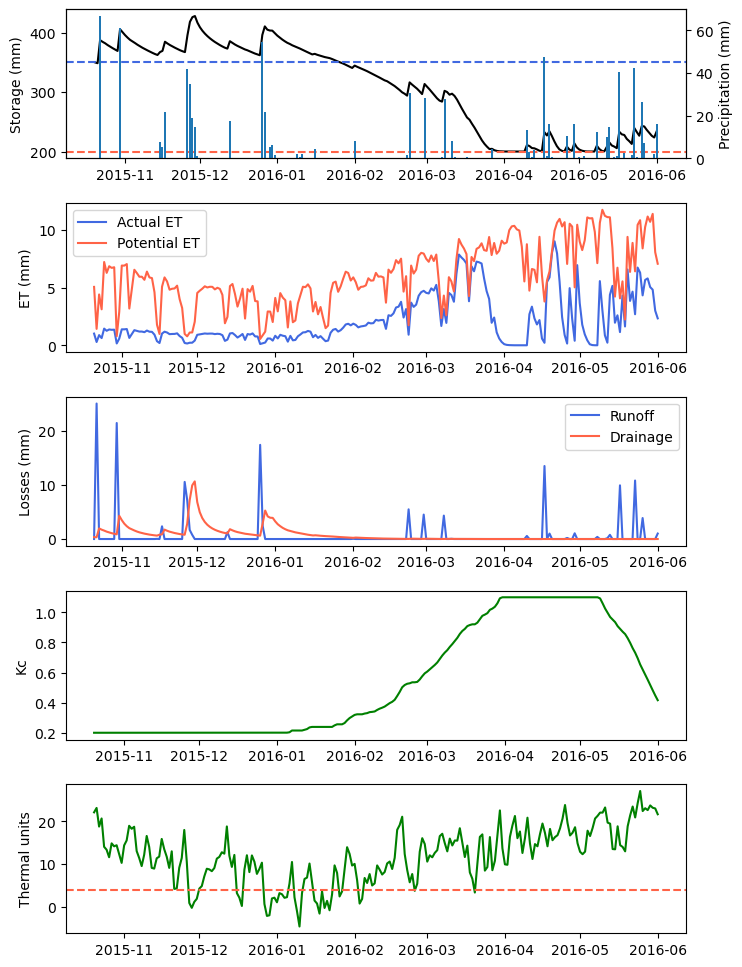

In [49]:
# Plot simulation
plt.figure(figsize=(8,12))

plt.subplot(5,1,1)
plt.plot(dates, S, color='k')
plt.axhline(FC, linestyle='--', color='royalblue')
plt.axhline(PWP, linestyle='--', color='tomato')
plt.ylabel('Storage (mm)')

plt.twinx()
plt.bar(dates, P)
plt.ylabel('Precipitation (mm)')

plt.subplot(5,1,2)
plt.plot(dates, ET, color='royalblue', label='Actual ET')
plt.plot(dates, PET, color='tomato', label='Potential ET')
plt.ylabel('ET (mm)')
plt.legend(loc='upper left')

plt.subplot(5,1,3)
plt.plot(dates, R, color='royalblue', label='Runoff')
plt.plot(dates, D, color='tomato', label='Drainage')
plt.ylabel('Losses (mm)')
plt.legend(loc='upper right')

plt.subplot(5,1,4)
plt.plot(dates, Kc, color='green', label='Crop Kc')
plt.ylabel('Kc')

plt.subplot(5,1,5)
plt.plot(dates, TAVG, color='green', label='Tavg')
plt.axhline(T_base, linestyle='--', color='tomato', label='Tbase')
plt.ylabel('Thermal units')

plt.subplots_adjust(hspace=0.3)
plt.show()


## Assumptions

- Interception depends on the amount of foliage, foliage architecture (e.g. leaf angle), the amount and type of crop stubble, and the evaporative demand during the rainfall event. Using a constant value for canopy and stubble interception is an acceptable approximation that filters small precipitation events that will not reach the soil surface, but this value needs to be carefully selected for each simulation scenario.

- The use of crop coefficients is a simple approximation to weight the ET of a reference crop to the crop under simulation. The timing of the crop coefficeints in this model is a simple approximation to capture the timing of the crop water demand.